In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
train_df = pd.read_csv("/kaggle/input/ai-201-b-mse-2-ai-c/train.csv")
test_df = pd.read_csv("/kaggle/input/ai-201-b-mse-2-ai-c/test.csv")

print(train_df.head())
print(train_df.shape)


   Gender        Age    Height      Weight family_history_with_overweight  \
0    Male  33.226808  1.766888   83.337721                            yes   
1  Female  18.000000  1.600000   55.000000                            yes   
2     NaN  26.000000  1.640741  111.930700                            yes   
3    Male  19.000000  1.690000   64.000000                             no   
4    Male        NaN  1.606474   94.189167                            yes   

  FAVC  FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  TUE  \
0  NaN   2.0       NaN   Sometimes    no  1.964435  no  0.750111  0.0   
1  yes   2.0  3.000000   Sometimes    no  2.000000  no  1.000000  1.0   
2  yes   3.0  3.000000   Sometimes    no  2.617988  no  0.000000  NaN   
3  yes   2.0       NaN  Frequently    no  2.000000  no  0.000000  1.0   
4  yes   2.0  2.812283   Sometimes    no  2.000000  no  1.000000  0.0   

        CALC                 MTRANS           NObeyesdad  
0         no             Automobile  Ov

In [6]:
X = train_df.drop("NObeyesdad", axis=1)
y = train_df["NObeyesdad"]


In [7]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)


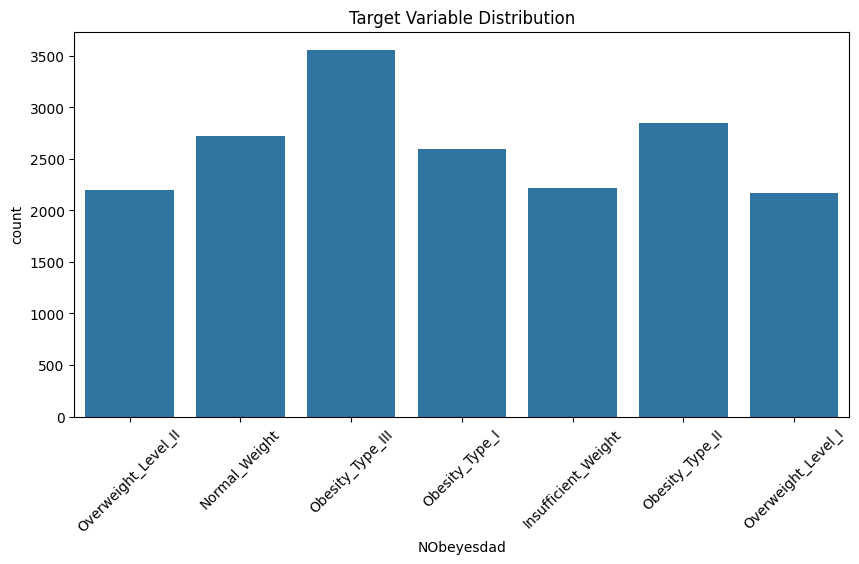

In [8]:
plt.figure(figsize=(10,5))
sns.countplot(x=y)
plt.xticks(rotation=45)
plt.title("Target Variable Distribution")
plt.show()


In [9]:
num_cols = X.select_dtypes(include=["int64","float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns


In [10]:
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])


In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)


In [12]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

model = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", rf_model)
])

model.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

In [13]:
y_pred = model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))


Accuracy: 0.8776624795193884

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.86      0.90       443
           1       0.81      0.87      0.84       544
           2       0.86      0.86      0.86       520
           3       0.96      0.96      0.96       570
           4       0.99      0.99      0.99       712
           5       0.77      0.75      0.76       434
           6       0.75      0.77      0.76       439

    accuracy                           0.88      3662
   macro avg       0.87      0.86      0.87      3662
weighted avg       0.88      0.88      0.88      3662



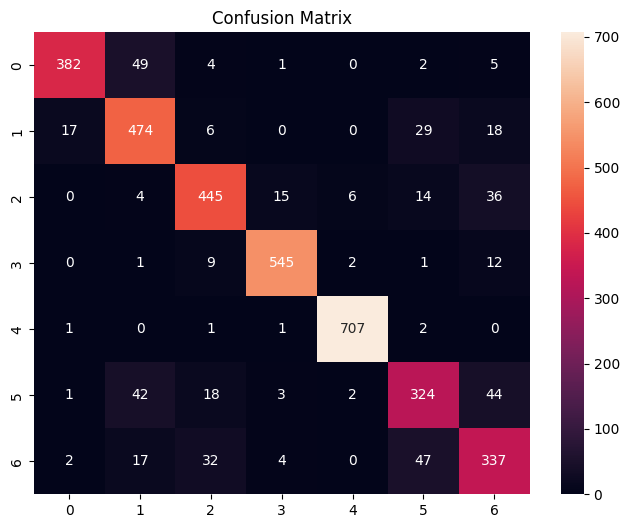

In [14]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()


In [15]:
param_grid = {
    "classifier__n_estimators": [100,200],
    "classifier__max_depth": [None,10,20],
    "classifier__min_samples_split": [2,5]
}

grid = GridSearchCV(
    model,
    param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)


Best Parameters: {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}


In [16]:
best_model = grid.best_estimator_


In [ ]:
final_model=best_model if 'best_model' in globals() else model

test_predictions = best_model.predict(test_df)

final_predictions = le.inverse_transform(test_predictions)

submission = pd.DataFrame({
    "NObeyesdad": final_predictions
})

submission.to_csv("final_predictions.csv", index=False)
print("✅ Predictions saved successfully!")


✅ Predictions saved successfully!
